# Non-negative Matrix Factorization With NBA Shot Data

### Preparation

In [1]:
# Import modules
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess as sp
import pickle # to serialize/unserialize python data objects

import helper_basketball as h
import imp
imp.reload(h);

import sklearn.decomposition as skld
from sklearn.externals import joblib

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

In [2]:
# This is our original data set:
allshots = pickle.load(open('allshots2016-17.pkl', 'rb'))
allmade = allshots
allmade[1:10]

,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,PlayerID
1,26,-160,205,1,1,203518
2,2,20,3,1,1,203518
3,26,-150,219,1,1,203518
4,26,-52,257,1,0,203518
5,27,145,232,1,0,203518
7,23,-230,46,1,0,203518
8,27,-178,208,1,0,203518
9,27,159,228,1,1,203518
10,3,4,33,1,0,203518


In [3]:
## bin edge definitions in inches
xedges = (np.linspace(start=-25, stop=25, num=151, dtype=np.float)) * 12
yedges = (np.linspace(start= -4, stop=31, num=106, dtype=np.float)) * 12

## 2d histogram containers for binned counts and smoothed binned counts
all_counts = {}
all_smooth = {}

## data matrix: players (row) by vectorized 2-d court locations (column)
for i, one in enumerate(allmade.groupby('PlayerID')):
    
    ## what does this line do?
    pid, pdf = one
    
    ## h.bin_shots: what is this function doing?
    tmp1, xedges, yedges = h.bin_shots(pdf, bin_edges=(xedges, yedges), density=True, sigma=2)
    tmp2, xedges, yedges = h.bin_shots(pdf, bin_edges=(xedges, yedges), density=False)
    
    ## vectorize and store into dictionary
    # see: https://stackoverflow.com/questions/18691084/what-does-1-mean-in-numpy-reshape
    all_smooth[pid] = tmp1.reshape(-1)
    all_counts[pid] = tmp2.reshape(-1)

In [4]:
# Specified Player ID Vector
len(all_smooth)

362

In [5]:
# create pickle storage file
pickle.dump(np.stack(all_smooth.values()).T, open('allpatterns2016-17.pkl', 'wb')) # transpose smoothings as pickle file 

In [6]:
# Un-serialize smoothed frequency values

X = pickle.load(open('allpatterns2016-17.pkl', 'rb'))  

In [7]:
def non_negative_matrix_decomp(n_components,train_data):
    import sklearn.decomposition as skld
    model = skld.NMF(n_components=n_components, init='nndsvda', max_iter=500, random_state=0)
    W = model.fit_transform(train_data)
    H = model.components_
    nmf = (W,H)
    return(nmf)

# ideal optimized chosen r value = 8-10 
r0 = 7
r1 = 8
r2 = 10

W_3,H_3 = non_negative_matrix_decomp(n_components = r0,train_data = X) # too small 
W_3_1,H_3_1 = non_negative_matrix_decomp(n_components = r1,train_data = X) # passing
W_3_2,H_3_2 = non_negative_matrix_decomp(n_components = r2,train_data = X) # a little better maybe 

In [ ]:
#W_3,H_3

In [8]:
X3_hat = np.matmul(W_3,H_3) # too small 
X31_hat = np.matmul(W_3_1,H_3_1) # passing
X32_hat = np.matmul(W_3_2,H_3_2) # passing 

Text(0.5,1,'Estimated Shooting Pattern (r=10)')

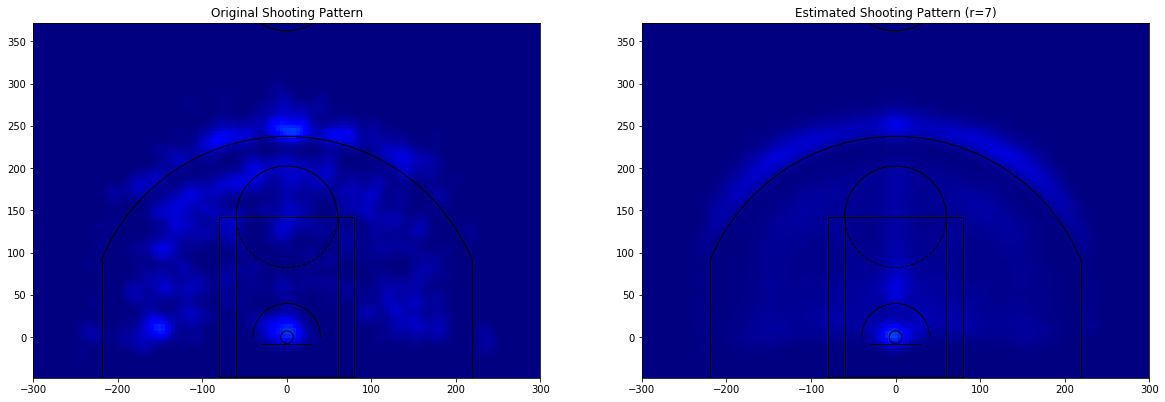

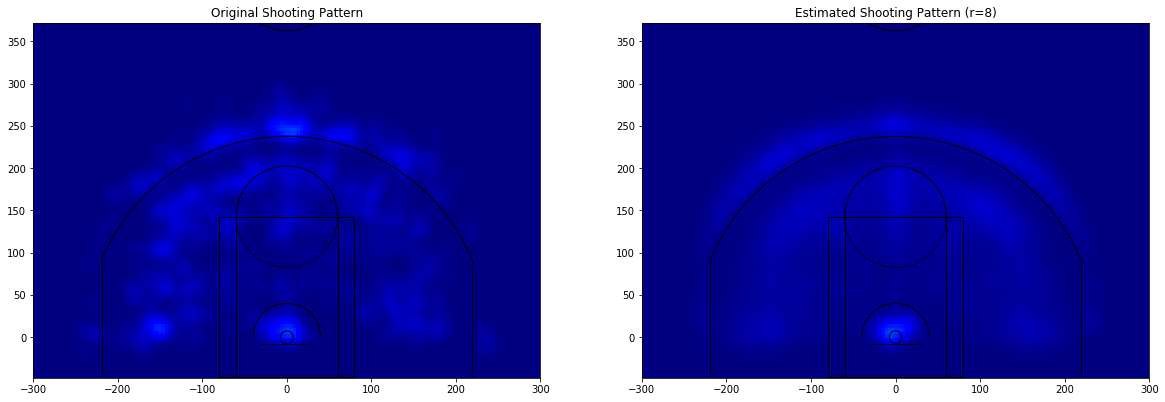

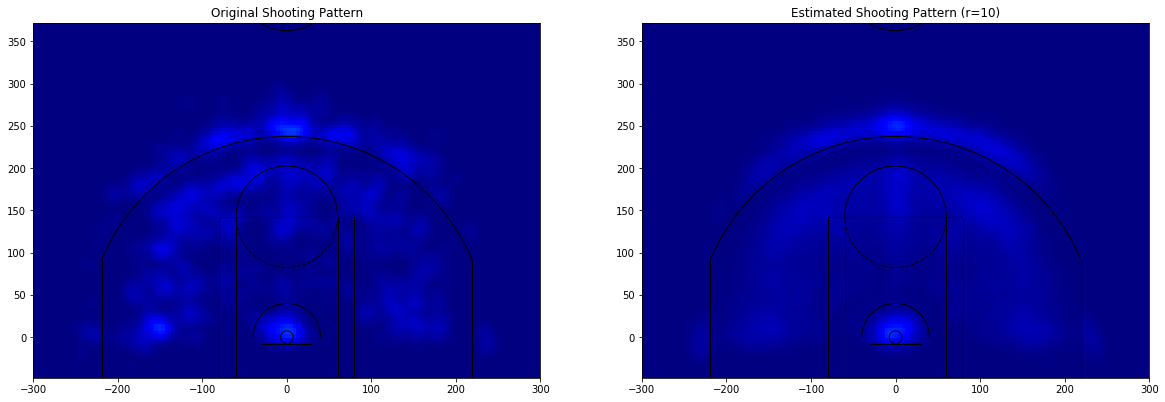

In [9]:
fig, ax = plt.subplots(1,2, figsize=(20,60))
fig, ax1 = plt.subplots(1,2, figsize=(20,60))
fig, ax2 = plt.subplots(1,2, figsize=(20,60))

# I took the first player appearing in first column 

# Checking the quality of the visualization to assess optimum r value 
h.plot_shotchart(X[:,1], xedges, yedges, ax=ax[0]) 
h.plot_shotchart(X3_hat[:,1], xedges, yedges, ax=ax[1])
ax[0].set_title('Original Shooting Pattern')
ax[1].set_title('Estimated Shooting Pattern (r=7)')

h.plot_shotchart(X[:,1], xedges, yedges, ax=ax1[0]) 
h.plot_shotchart(X31_hat[:,1], xedges, yedges, ax=ax1[1])
ax1[0].set_title('Original Shooting Pattern')
ax1[1].set_title('Estimated Shooting Pattern (r=8)')

h.plot_shotchart(X[:,1], xedges, yedges, ax=ax2[0]) 
h.plot_shotchart(X32_hat[:,1], xedges, yedges, ax=ax2[1])
ax2[0].set_title('Original Shooting Pattern')
ax2[1].set_title('Estimated Shooting Pattern (r=10)')

## Part 1: Experimenting With n_components 

From the above 3 visualizations using r = 7, 8, and 10 respectively, we can make a reasonable conclusion about when the r-value becomes to small. It is apparent that with an r value of 7, the diversity in the visualization is sparse. Therefore, r = 7 does not offer an accurate estimated shooting pattern for the data. If we then look at the visualization with r = 8, we can see that it is incorporates much more diversity and is a fuller more accurate representation of the original shooting pattern data. From this, we can deduce that the cutoff value for which r becomes to small is r = 7. Anything r values less than or equal to 7 will not result in a good estimate.

Next, we look at the last visualization with r = 10. In this visualziation, we can see that the estimated shot pattern has only very subtely changed. The increase in diversity is tapering off. However, I would conclude that r = 10 still produces a slightly more accurate result if we pay attention to the heat mappings around the 3-point line. Visualizations with anything above r = 10 did not change much or become significantly more accurate. The estimated shot pattern with r = 20 was nearly indistinguishable from that when r = 10. From this, I will conclude that any r values above 10 are too large and result in duplicated bases. 

## Part 2: Correlations 

The X matrix is an p x n matrix, where n = 362 is the number of observations (players) and p = 15750 is the number of features. Therefore, the X matrix has 15750 rows and 362 columns. Since we are computing the correlation matrix of the columns (features), we want to compute the correlation of $X^T$, the transpose of matrix X. Therefore, our resultant correlation matrix R is a n x n matrix.  

In [10]:
X.shape

(15750, 362)

In [11]:
# Calcualte Correlations of Players Shot Instances  
R = np.corrcoef(X,rowvar=0) # Transpose to compute correlation between columns
R.shape

(362, 362)

### 2.1 Correlation Matrix Visualization 

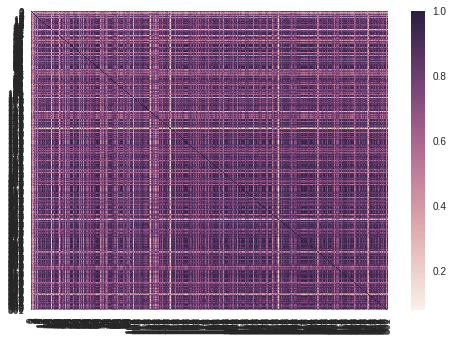

In [12]:
# Visualize R, correlation matrix, using Seaborn heatmap 
import seaborn as sns; sns.set()
ax = sns.heatmap(R)

### 2.2 Player Similarities: Minimum and Maximum Correlations

In [13]:
# Copy matrix R into object R2, change diagonal of 1's to 0's, use this for finding the max 
R2 = R.copy()

In [14]:
R2

array([[ 1.        ,  0.48840093,  0.6172336 , ...,  0.85332746,
         0.68627375,  0.72179806],
       [ 0.48840093,  1.        ,  0.24589216, ...,  0.40060274,
         0.36499611,  0.35406752],
       [ 0.6172336 ,  0.24589216,  1.        , ...,  0.56694034,
         0.55138416,  0.45384762],
       ..., 
       [ 0.85332746,  0.40060274,  0.56694034, ...,  1.        ,
         0.56849095,  0.91837964],
       [ 0.68627375,  0.36499611,  0.55138416, ...,  0.56849095,
         1.        ,  0.44465658],
       [ 0.72179806,  0.35406752,  0.45384762, ...,  0.91837964,
         0.44465658,  1.        ]])

In [15]:
# Change diagonal of 1's to 0's 
np.fill_diagonal(R2, 0)

In [16]:
R2

array([[ 0.        ,  0.48840093,  0.6172336 , ...,  0.85332746,
         0.68627375,  0.72179806],
       [ 0.48840093,  0.        ,  0.24589216, ...,  0.40060274,
         0.36499611,  0.35406752],
       [ 0.6172336 ,  0.24589216,  0.        , ...,  0.56694034,
         0.55138416,  0.45384762],
       ..., 
       [ 0.85332746,  0.40060274,  0.56694034, ...,  0.        ,
         0.56849095,  0.91837964],
       [ 0.68627375,  0.36499611,  0.55138416, ...,  0.56849095,
         0.        ,  0.44465658],
       [ 0.72179806,  0.35406752,  0.45384762, ...,  0.91837964,
         0.44465658,  0.        ]])

In [17]:
# Compute minimum of original R correlation matrix without 1's replaced by 0's
mini = np.min(R)
mini

0.078895516904662413

In [18]:
# Compute maximum of modified R2 correlation matrix
maxi = np.max(R2)
maxi

0.99667799324460904

In [19]:
# Compute second-most minimum with R matrix
flatR = R.flatten()                    # flatten matrix into vector-array 
mini2 = np.partition(flatR, 2)[2]      # 2 will give us second-min, as 0 and 1 are both alotted to 1st-min 
mini2

0.081817077472911601

In [20]:
# Compute second-most maximum with R2 matrix
flatR2 = R2.flatten()                  # flatten matrix into vector-array
maxi2 = np.partition(flatR2, -3)[-3]   # -3 will give us second-max, as -1 and -2 are both alotted to 1st-max
maxi2

0.9958828102499766

In [21]:
# Store indices for minimum 
ind_min = np.where(R == mini)
ind_min

(array([23]), array([251]))

In [22]:
# Store indices for maximum 
ind_max = np.where(R2 == maxi)
ind_max

(array([283]), array([235]))

In [23]:
# Store indices for 2nd-min 
ind_2min = np.where(R == mini2)
ind_2min

(array([21, 28]), array([28, 21]))

In [24]:
# Store indices for 2nd-max 
ind_2max = np.where(R2 == maxi2)
ind_2max

(array([101]), array([243]))

### 2.3: Find Player ID and Player Name Combinations (for Minimums/Maximums)

In [25]:
# 1st min player id 1
play1_min = list(all_smooth.keys())[23]
play1_min

2733

In [26]:
# 1st min player id 2
play2_min = list(all_smooth.keys())[251]
play2_min

203584

In [27]:
# 2nd min player id 1
play1_min2 = list(all_smooth.keys())[21]
play1_min2

2594

In [28]:
# 2nd min player id 2
play2_min2 = list(all_smooth.keys())[28]
play2_min2

2744

In [29]:
# 1st max player id 1 
play1_max = list(all_smooth.keys())[283]
play1_max

203991

In [30]:
# 1st max player id 2
play2_max = list(all_smooth.keys())[235]
play2_max

203497

In [31]:
# 2nd max player id 1
play1_max2 = list(all_smooth.keys())[101]
play1_max2

201599

In [32]:
# 2nd max player id 2
play2_max2 = list(all_smooth.keys())[243]
play2_max2

203512

In [33]:
# LOAD PLAYER DATA

## get all 2016-17 teams
params = {'LeagueID':'00','Season': '2016-17'}
teams = h.get_nba_data('commonTeamYears', params).set_index('TEAM_ID')
allteams = teams.loc[teams.MAX_YEAR=='2017'].index.values

## get all 2016-17 players
params = {'LeagueID':'00', 'Season': '2016-17', 'IsOnlyCurrentSeason': '0'}
players = h.get_nba_data('commonallplayers', params).set_index('PERSON_ID')
allplyrs = players.loc[players.TEAM_ID.isin(allteams)].index.values

In [34]:
# Find Respective Player Names 
min_play1name = players.loc[play1_min][1] # vs 
min_play2name = players.loc[play2_min][1] 
min2_play1name = players.loc[play1_min2][1] # vs
min2_play2name = players.loc[play2_min2][1]
max_play1name = players.loc[play1_max][1] # vs
max_play2name = players.loc[play2_max][1]
max2_play1name = players.loc[play1_max2][1] # vs
max2_play2name = players.loc[play2_max2][1]

print('The minimum correlated players are', min_play1name, "vs.", min_play2name)
print('The second-most minimum correlated players are', min2_play1name, "vs.", min2_play2name)
print('The maxiumum correlated players are', max_play1name, "vs.", max_play2name)
print('The second-most maximum correlated players are', max2_play1name, "vs.", max2_play2name)

The minimum correlated players are Shaun Livingston vs. Troy Daniels
The second-most minimum correlated players are Kyle Korver vs. Al Jefferson
The maxiumum correlated players are Clint Capela vs. Rudy Gobert
The second-most maximum correlated players are DeAndre Jordan vs. Lucas Nogueira


### 2.4 Visualize Original Shooting Patterns of Most Correlated and Least Correlated Players

Text(0.5,1,'2nd Maximum: Lucas Nogueira Original Shooting Pattern')

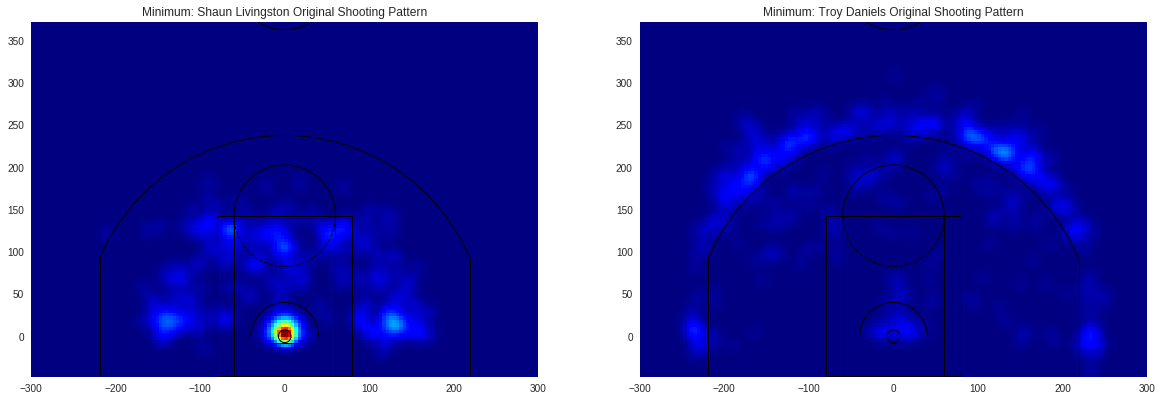

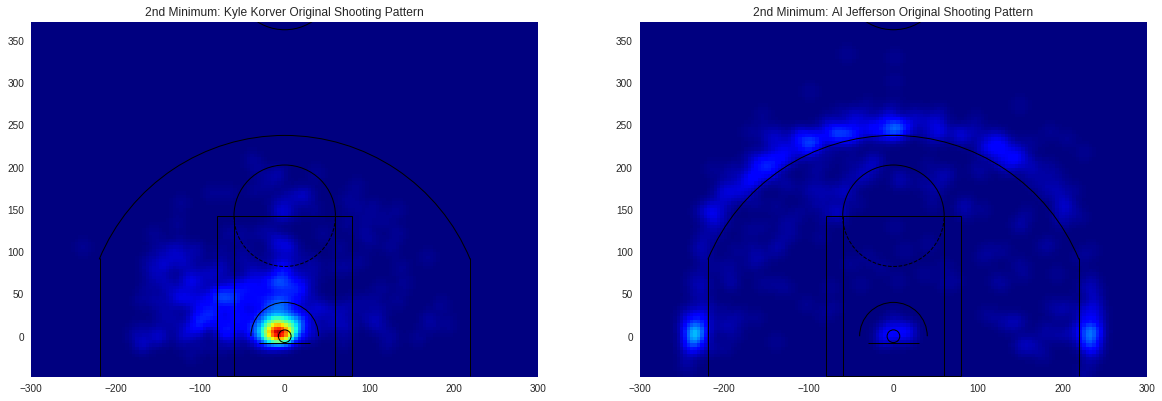

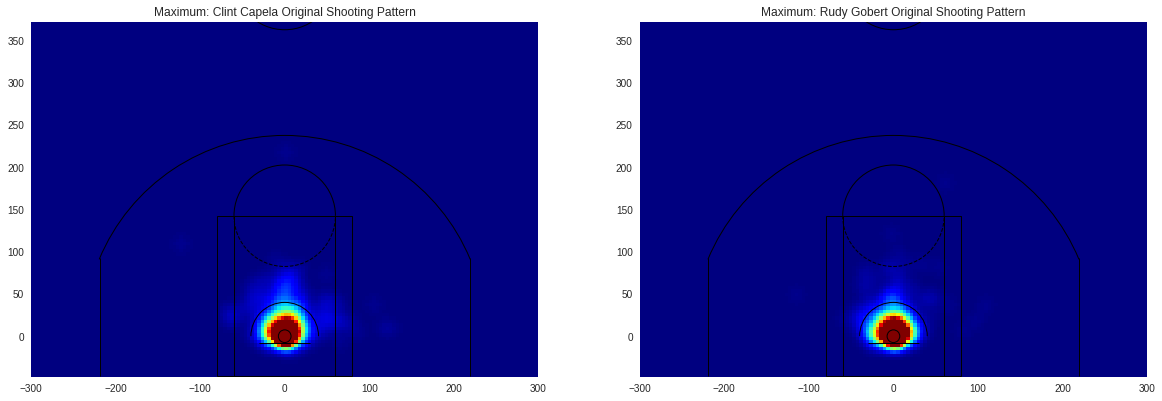

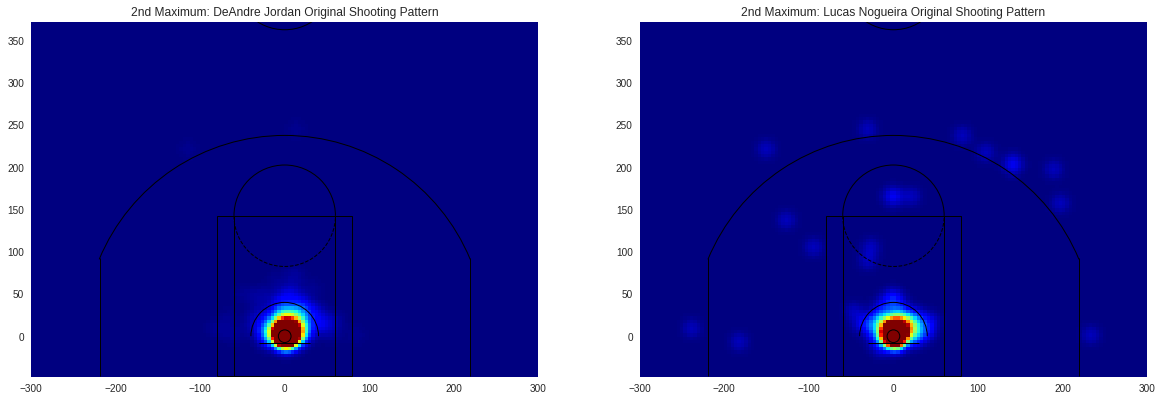

In [35]:
fig, ax = plt.subplots(1,2, figsize=(20,60))    # min correlation players
fig1, ax1 = plt.subplots(1,2, figsize=(20,60))   # 2nd min correlation players
fig2, ax2 = plt.subplots(1,2, figsize=(20,60))   # max correlation players
fig3, ax3 = plt.subplots(1,2, figsize=(20,60))   # 2nd max correlation players 

# Plot Heatmaps of Correlated Players 

# Min Correlation 
h.plot_shotchart(X[:,23], xedges, yedges, ax=ax[0]) 
h.plot_shotchart(X[:,251], xedges, yedges, ax=ax[1])
ax[0].set_title('Minimum: Shaun Livingston Original Shooting Pattern')
ax[1].set_title('Minimum: Troy Daniels Original Shooting Pattern')

# 2nd Min Correlation 
h.plot_shotchart(X[:,28], xedges, yedges, ax=ax1[0]) 
h.plot_shotchart(X[:,21], xedges, yedges, ax=ax1[1])
ax1[0].set_title('2nd Minimum: Kyle Korver Original Shooting Pattern')
ax1[1].set_title('2nd Minimum: Al Jefferson Original Shooting Pattern')

# Max Correlation  
h.plot_shotchart(X[:,283], xedges, yedges, ax=ax2[0]) 
h.plot_shotchart(X[:,235], xedges, yedges, ax=ax2[1])
ax2[0].set_title('Maximum: Clint Capela Original Shooting Pattern')
ax2[1].set_title('Maximum: Rudy Gobert Original Shooting Pattern')

# 2nd Max Correlation  
h.plot_shotchart(X[:,101], xedges, yedges, ax=ax3[0]) 
h.plot_shotchart(X[:,243], xedges, yedges, ax=ax3[1])
ax3[0].set_title('2nd Maximum: DeAndre Jordan Original Shooting Pattern')
ax3[1].set_title('2nd Maximum: Lucas Nogueira Original Shooting Pattern')

### 2.5: Observations From Shooting Patterns of Players With Highest/Lowest Correlation 

Above, we can see vizualizations of those players with the highest and lowest correlation in shot patterns. Both the minimum correlation players and the second-minimum correlation players have very similar relationships. We can observe that those players with low correlation in shot patterns in this case are players who's shot patterns lie within the 3-point line vs. those who's shot patterns are heavily on and around the 3-point line. Both the maximum correlation players and the second-maximum correlation players also have similar relationships. We observe in these cases that the highly correlated player shot patterns illustrate players with shot patterns which are highly concentrated at the blocks or around the hoop. 

### 2.6: Hierarchical Clustering of Correlation Matrix R

In [36]:
Z = linkage(X.T,method='complete',metric='correlation')   

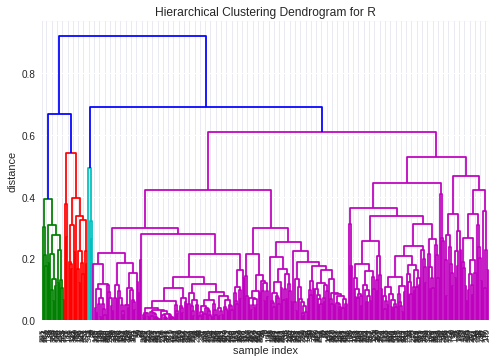

In [37]:
plt.title('Hierarchical Clustering Dendrogram for R')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

## Part 3: Discriminating Player Types

Below we have the shape of our two factorized components with r = 10 bases. 

In [38]:
# 10 bases
H_3_2.shape

(10, 362)

In [39]:
# 10 bases
W_3_2.shape

(15750, 10)

### 3.1: Interpretation of H Coefficients

The H matrix is a n x r (362 x 10) matrix with 10 rows corresponding to the chosen number of bases (r) and 362 columns corresponding to the players (n). Each player has 10 coefficients for each respective basis. Each of these 10 coefficients is a weight multiplier which defines the rank or importance of the respective feature (shot location) in the matrix W (r x p, where p = 15750). When these to matrices are multiplied, we can attain an accurate reconstruction of the most valuable and important features of original matrix X. This is why the reconstruction is a condensed version of the original X matrix, without containing all information. 

Considering the above information, players with closely-related shooting patterns should also have a similar assortment of values for weighting coefficients. We should be able to group the n = 362 players into meaningful player types by assessing those players with similar combinations of cell values (coefficients). 

### 3.2: Standardization of Player Coefficients

In order to discriminate player types, we will perform a hierarchical clustering of the coefficients in matrix H, to group together those players with similar weightings. However, before exploring possible groupings for players, we will want to standardize the player coefficients so that they are scaled to sum to 1. This will provide for more accurate meaning in computations using distance metrics. 

In [40]:
# Standardize H Coefficient Matrix
play_coef = pd.DataFrame(H_3_2, columns=all_smooth.keys())
#play_coef.T

play_coef /= play_coef.sum(0)  # standardize players, i.e. scale to sum to 1
play_coef.T.head()

,0,1,2,3,4,5,6,7,8,9
1713,0.133608,0.277006,0.076144,0.025520,0.044162,0.055316,0.105243,0.019998,0.171687,0.091317
1717,0.037943,0.020051,0.016342,0.064672,0.016537,0.000000,0.000000,0.445927,0.372312,0.026216
1891,0.126057,0.119488,0.024710,0.000000,0.041369,0.223977,0.043378,0.000000,0.014251,0.406768
1938,0.082574,0.270972,0.041000,0.243964,0.062168,0.033837,0.052958,0.021993,0.096120,0.094414
2037,0.000000,0.100539,0.104066,0.000000,0.099417,0.091536,0.122061,0.282051,0.151030,0.049299


In [41]:
# Shape remains consistent to H matrix
play_coef.shape

(10, 362)

### 3.3: Hierarchical Clustering, Grouping Player Types

Below, we perform hierarchical clustering using the "euclidean" distance metric. After significant research, I found that "euclidean" distance metric should be compute meaningful distances in this case. For the case above where we were exploring correlations with the X matrix, the "correlation" distance metric was more suitable. This is because the X matrix is p x n, composed of n = 362 columns of players and p = 15750 possible features with each cell equal to frequencies of particular features for each player. If "euclidean" distance were used in this case, then players who take very few shots would be clustered together; this is not ideal. If the "correlation" distance metric is used in this situation, players with similar shot patterns or locations are be clustered together; this was ideal for the above case in Problem 2.

In the case below, we are using matrix H, and we want to cluster players with similar weighting coefficient values together, as these players should have similar similar shooting-styles and patterns. The H matrix coefficient values however, are measurements of shot location rank (importance), unlike the frequencies in matrix X. In this case, we want to measure how similar the values are to one another, not how correlated they are. The "euclidean" distance metric will allow us to do this. 

In [42]:
# hierarchical clustering with euclidean distance metric
Z3 = linkage(play_coef.T, method="complete", metric="euclidean")   # transpose to take difference between rows

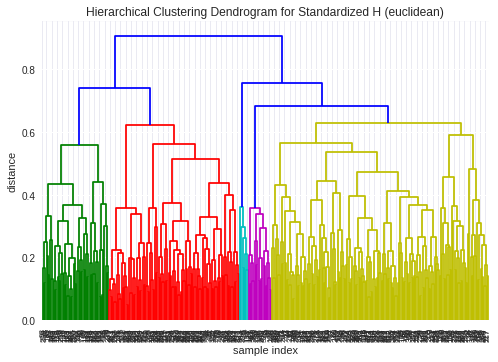

In [43]:
plt.title("Hierarchical Clustering Dendrogram for Standardized H (euclidean)")
plt.xlabel("sample index")
plt.ylabel("distance")
dendrogram(
    Z3,
    leaf_rotation=90.,   # rotates the x-axis labels
    leaf_font_size=8.,   # font size for x-axis labels 
)
plt.show()

#### Analysis

The above clustering dendrogram illustrates clusters which appear to me to be reasonable and according to expectation. 

Observing some of the player shot patterns in Problem 2, I noticed most players either had patterns of shooting mostly in the box and near the hoop at the blocks, outside the box and in the 2-point zone, or further outside around the 3-point zone. And of course, some were mixed, the jacks of all trades and masters of none. The mixed shooters were often those with shot patterns inside the box and outside in the 2-point zone (short-to-mid range) or in both the 2-point and 3-point range (mid-to-long range). These analyses and assumptions leave us with 5 groups. Perhaps, our clustering makes sense, as we see 5 clusters in the above visualization.

When we compare the above player type discrimination to the K-Means clustering performed [here](https://fastbreakdata.com/classifying-the-modern-nba-player-with-machine-learning-539da03bb824), we see similarities as well. This resource shows 8 clusters. Although our tree clustering only produced 5 clusters, this may make sense since the data was subsetted to include only those players who take a larger amount of shots. Therefore, in the data we are working with, we have dropped most of the defensive players who take and make few shots. The above resource includes defensive players and the larger variation in their data may account for the 3 additional clusters. 

It is possible to verify my intuition in regards to the above tree clustering, however extraction of further information about players in each cluster is not a simple task with the dendrogram function. Further exploration would require extensive code. 

## Part 4: Conclusions ("In Charge of a Team")

If I were in charge of a basketball team, I could use this information in many ways. If I could cluster the players on my team and attribute a shooting pattern type to each player, I would be able to make guesses and conclusions as to which players may work well together and which players may be redundant to have on the court at the same time. Say, if two players have very similar shooting styles, unless they manned opposite ends of the court, it would probably be unnecessary and ineffective to play them at the same time in the game. It would be more useful to keep one of the two players on the bench at all times and use them as substitutes for one another. 

In addition to making decisions in regards to those players already on the team, the information explored in the above data analysis would be astronomically profound in helping me ("THE COACH") select and draft new players for the team. Since we can group all players on our team and in the NBA by type, we would be able to see which types of players our team is deficient in, perhaps giving us ideas as to who we would prioritize in the upcoming draft offerings.

Questions I would like to dive further into would be which players in particular belong to which of the above clusters in Problem 3. I would want to be able to verify the value and meaning of these clusters by extracting various player names from the 5 dendrogram clusters and plotting their shot patterns, maybe going even further by computing within-cluster correlations to be sure my work displays accurate relationships. This would make possible validation of results and make the data exploration much more useful, but would require extensive code. 

Without knowing the particular players in each cluster, we would still be able to get an idea of types of players and make assumptions based on visualized shooting patterns as to which players belong in which type-group. 